In [1]:
!pip install keras

     |████████████████████████████████| 1.6 MB 621 kB/s eta 0:00:01


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default")
import seaborn as sns
import six

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

2022-07-27 09:33:34.494979: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# Création des fonctions
def get_dataframe(path, n_breeds=12):
    dogs_lst = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            dogs_lst.append(os.path.join(dirname, filename))

    # Je stocke dans un dataframe
    dogs_raw = pd.DataFrame(dogs_lst, columns=['uri'])

    # J'extrais la race
    dogs_raw['breeds'] = dogs_raw.uri.str.split('/').str.get(5).str.slice(10)
    
    # Délimitation du nombre de race
    top_breeds = dogs_raw.groupby('breeds').count().sort_values(by='uri', ascending=False).head(n_breeds).reset_index().breeds.to_list()
    dogs = pd.DataFrame()
    for b in top_breeds:
        dogs = dogs.append(dogs_raw[dogs_raw.breeds == b])

    return dogs


def split_and_generate_dataframe(df, px):
    seed = 42

    # Séparation des données d'entrainements et de tests
    train, test = train_test_split(df, test_size=0.2, random_state=seed)
    # Séparation des données d'entrainements et de validation
    train, val = train_test_split(train, test_size=0.2, random_state=seed)

    ### Paramétrage
    x = 'uri'
    y = 'breeds'

    train_batch_size = get_batch_size(len(train))
    val_batch_size = get_batch_size(len(val))
    test_batch_size = get_batch_size(len(test))

    train_datagen = ImageDataGenerator(rescale=1./255)
    train_datagen_aug = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Sans augmentation des données
    train_gen = train_datagen.flow_from_dataframe(
                      train,
                      x_col='uri',
                      y_col='breeds',
                      target_size=(px, px),
                      batch_size=train_batch_size,
                      seed=seed
                      )


    # Avec augmentation des données
    train_gen_data_aug = train_datagen_aug.flow_from_dataframe(
                              train,
                              x_col='uri',
                              y_col='breeds',
                              target_size=(px, px),
                              batch_size=train_batch_size,
                              seed=seed
                              )

    val_gen = val_test_datagen.flow_from_dataframe(
                      val,
                      x_col = x,
                      y_col = y,
                      target_size=(px, px),
                      batch_size=val_batch_size,
                      seed=seed
                      )

    test_gen = val_test_datagen.flow_from_dataframe(
                      test,
                      x_col = x,
                      y_col = y,
                      target_size=(px, px),
                      batch_size=test_batch_size,
                      seed=seed,
                      shuffle=False
                      )

    return [train_gen, train_gen_data_aug, val_gen, test_gen]

def get_batch_size(gen):
    lst = []
    dict = {}
    
    # Test des nombres entiers et intégration dans un dictionnaire
    for i in range(1,40):
        dict[i] = gen % i
    
    # Récupération du plus grand nombre entiers
    for key, value in dict.items():
        if value == 0:
            lst.append(key)

    return max(lst)


def get_model():
    model = Sequential()
    model.add(conv_base)
    model.add(GlobalAveragePooling2D())
    # model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(len(train_gen.class_indices), activation='softmax'))
    return model


def train_model(train):
    model_train = get_model()
    model_train.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    history_train = model_train.fit(train,
                                validation_data=val_gen,
                                epochs=epochs,
                                verbose=verbose,
                                callbacks=[early_stopping_monitor, model_save])
    
    plot_result_fitting(history_train, name, title, n_breeds)
    plot_confusion_matrix(model_train, name, title, n_breeds)
    
    return model_train.evaluate(test_gen)[1]


def plot_result_fitting(history, model, title, n_breeds):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
    ax[0].set_title('Accuracy | ' + model + ' | ' + title + ' | ' + str(n_breeds) + ' breeds')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='loss')
    ax[1].plot(history.history['val_loss'], label = 'val_loss')
    ax[1].set_title('Loss function | ' + model + ' | ' + title + ' | ' + str(n_breeds) + ' breeds')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.savefig('./cnn_transfer_learning_' + model + '_' + title + '_' + str(n_breeds) + '_breeds_results.png',
                transparent=True)
    plt.show()
    return None


def export_png_table(data, col_width=2.2, row_height=0.625, font_size=10,
                     header_color='#7451eb', row_colors=['#f1f1f2', 'w'],
                     edge_color='w', bbox=[0, 0, 1, 1], header_columns=1,
                     ax=None, filename='table.png', **kwargs):
    ax = None
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])
                ) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox,
                         colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])

    fig.savefig(filename, transparent=True)

    return None

def plot_confusion_matrix(model, name, title, n_breeds):
    pred = model.predict_classes(test_gen)
    cf_matrix = confusion_matrix(test_gen.classes, pred)
    sns.heatmap(cf_matrix, cmap='Purples')
    plt.title('Matrice de confusion  | ' + name + ' | ' + title + ' | ' + str(n_breeds) + ' breeds')
    plt.axis('off')
    plt.savefig('./cnn_transfer_learning_' + name + '_' + title + '_' + str(n_breeds) + '_breeds_confusion_matrix.png',
                transparent=True)
    plt.show()
    return

---
# 1. Phase d'expérimentation | Charge 10 % (12 races)

L'expérimentation se fait en 3 étapes :
* Formation d'un modèle naif servant de baseline,
* Formation d'un modèle avec augmentation des données,
* Formation d'un modèle avec augmentation des données et fine tuning

3 modèles sont testés dans cette phase d'expérimentation : VGG16, InceptionV3, Xception

Les résultats sur les données des tests sont comparés. Les sorties d'entraînements accuracy et loss sont analysés afin de détecter un éventuel surapprentissage.

Nous avons 12 races sélectionnées pour la phase d'expérimentation.
Evaluation de VGG16 en cours...
Found 1694 validated image filenames belonging to 12 classes.
Found 1694 validated image filenames belonging to 12 classes.
Found 424 validated image filenames belonging to 12 classes.
Found 530 validated image filenames belonging to 12 classes.


2022-07-27 09:33:44.073437: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-27 09:33:44.077084: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-27 09:33:44.145182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 09:33:44.146229: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-07-27 09:33:44.146317: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-07-27 09:33:44.197938: I tensorflow/stream_executor/platform/def

58892288/58889256 [==============================] - 0s 0us/step


2022-07-27 09:33:48.220959: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-27 09:33:48.227760: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz
2022-07-27 09:33:49.090719: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-07-27 09:33:50.264595: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-07-27 09:33:50.291683: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping


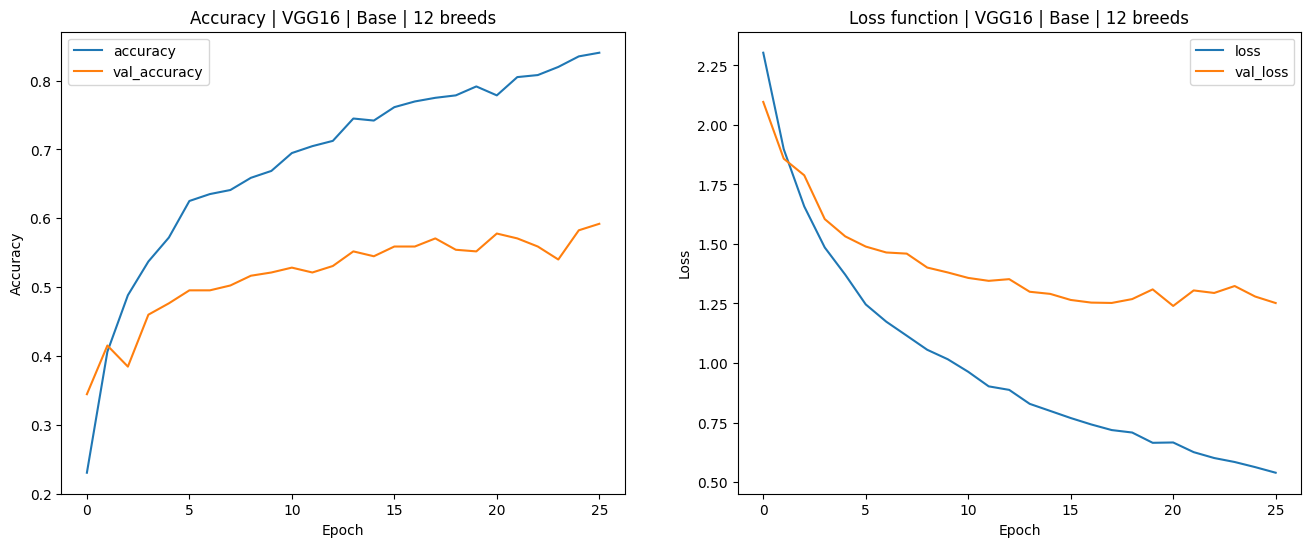

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


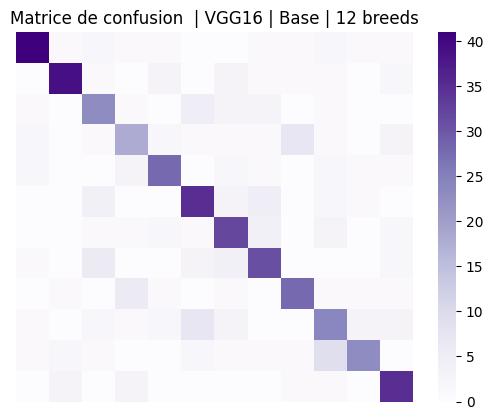

53/53 [==============================] - 3s 56ms/step - loss: 1.0193 - accuracy: 0.6736
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping


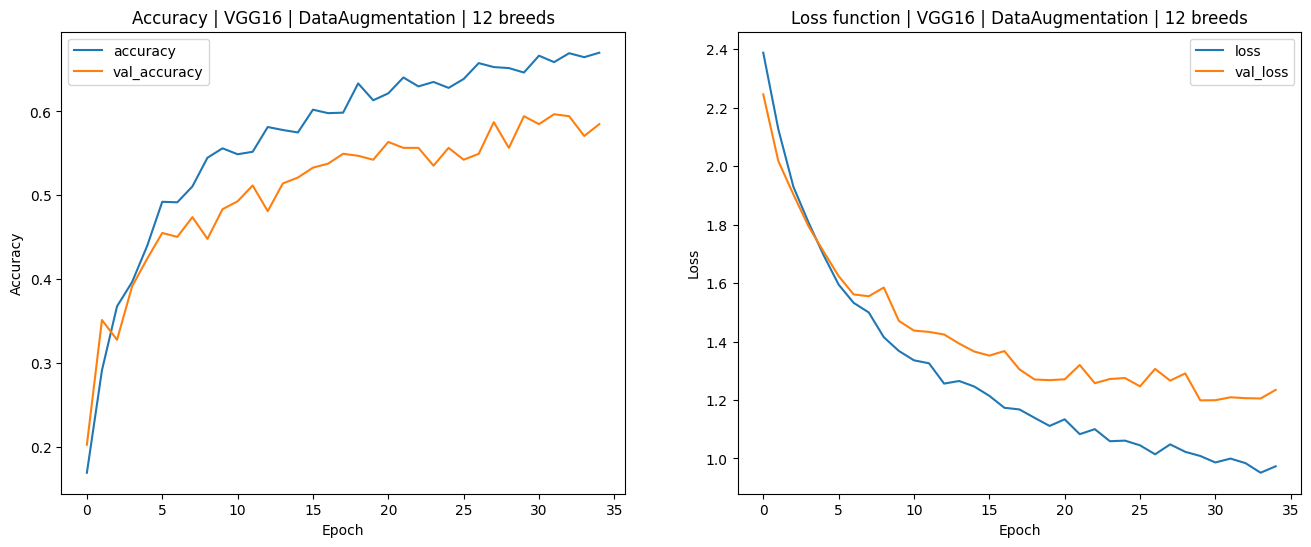

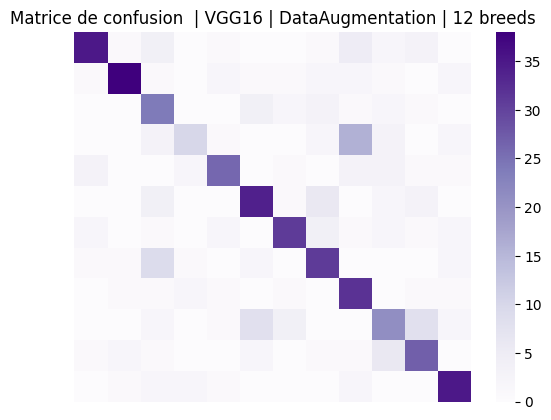

53/53 [==============================] - 3s 51ms/step - loss: 1.0369 - accuracy: 0.6491
Nombre de poids entraînable de VGG16 avant dégel partiel : 0
Nombre de poids entraînable de VGG16 après dégel partiel : 6
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


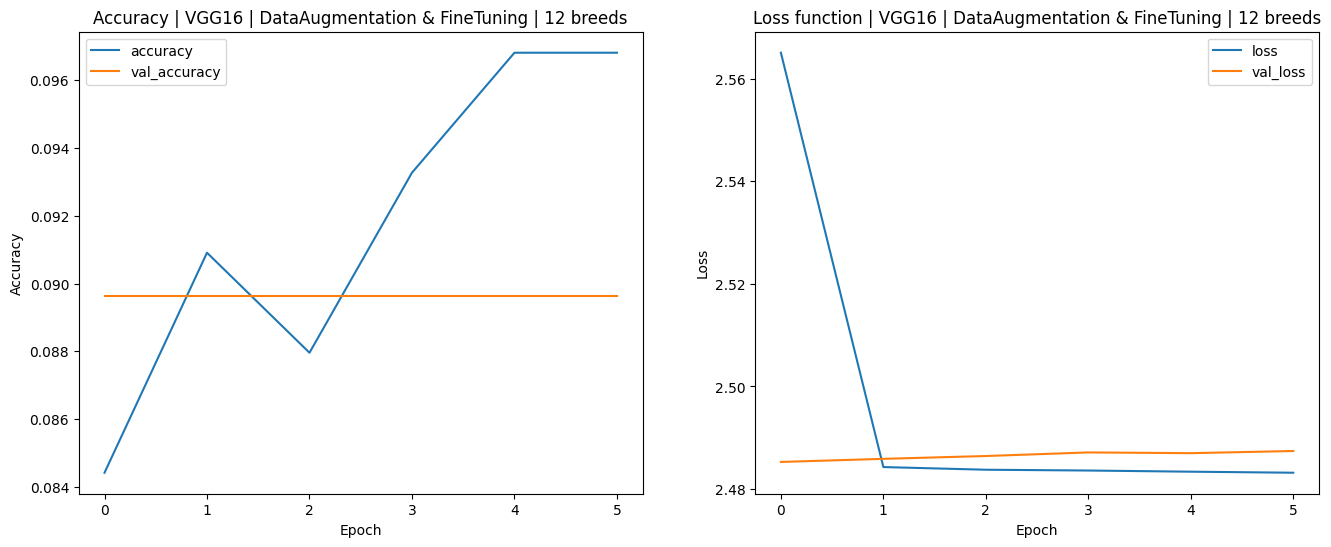

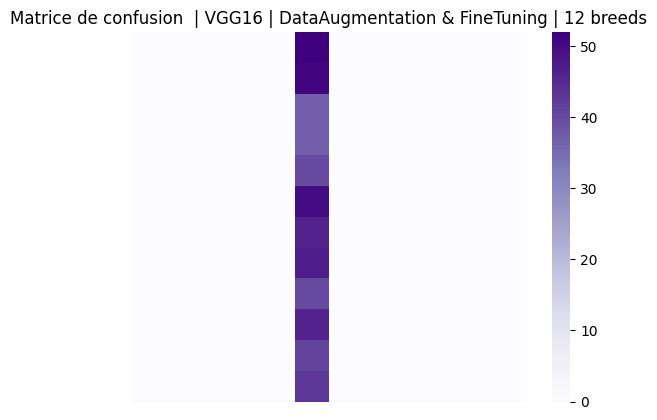

53/53 [==============================] - 3s 49ms/step - loss: 2.4840 - accuracy: 0.0943
Evaluation de ResNet50 en cours...
Found 1694 validated image filenames belonging to 12 classes.
Found 1694 validated image filenames belonging to 12 classes.
Found 424 validated image filenames belonging to 12 classes.
Found 530 validated image filenames belonging to 12 classes.
94773248/94765736 [==============================] - 1s 0us/step
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping


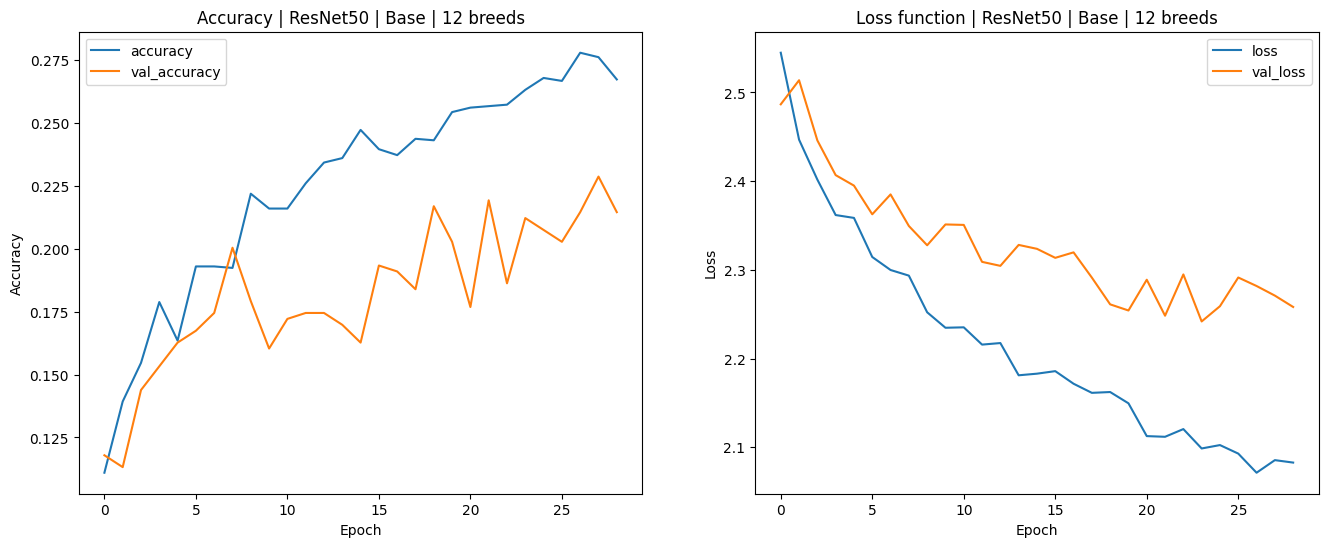

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


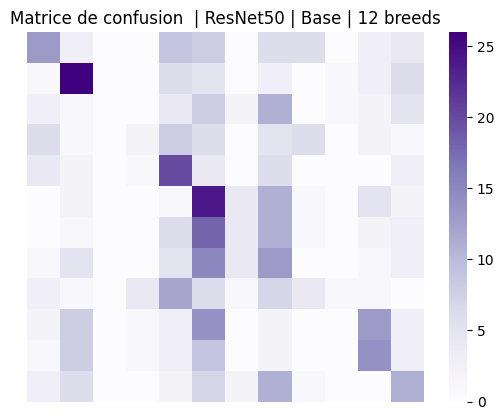

53/53 [==============================] - 3s 50ms/step - loss: 2.1412 - accuracy: 0.2472
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping


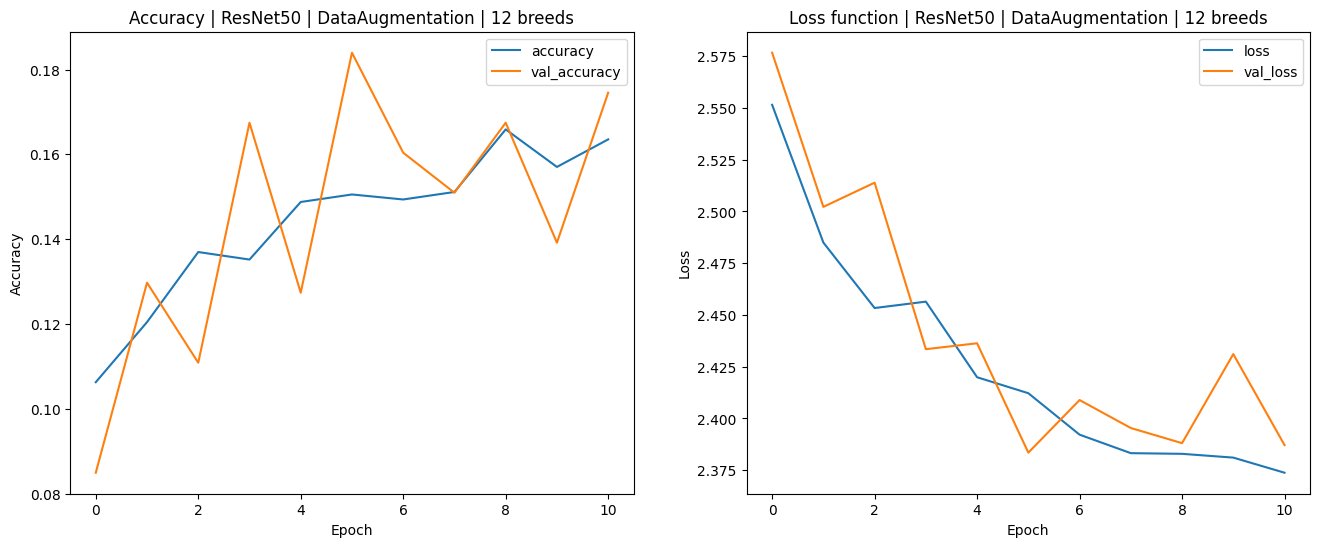

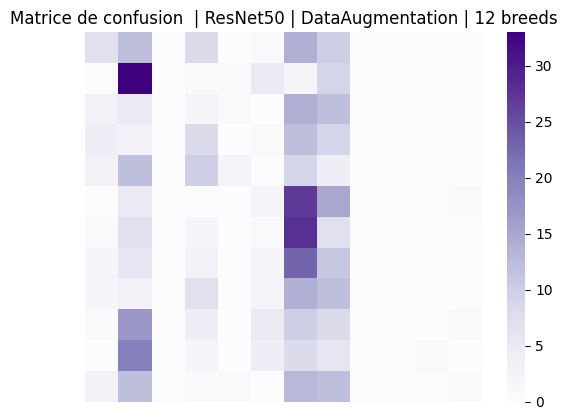

53/53 [==============================] - 3s 50ms/step - loss: 2.3828 - accuracy: 0.1755
Nombre de poids entraînable de ResNet50 avant dégel partiel : 0
Nombre de poids entraînable de ResNet50 après dégel partiel : 20
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping


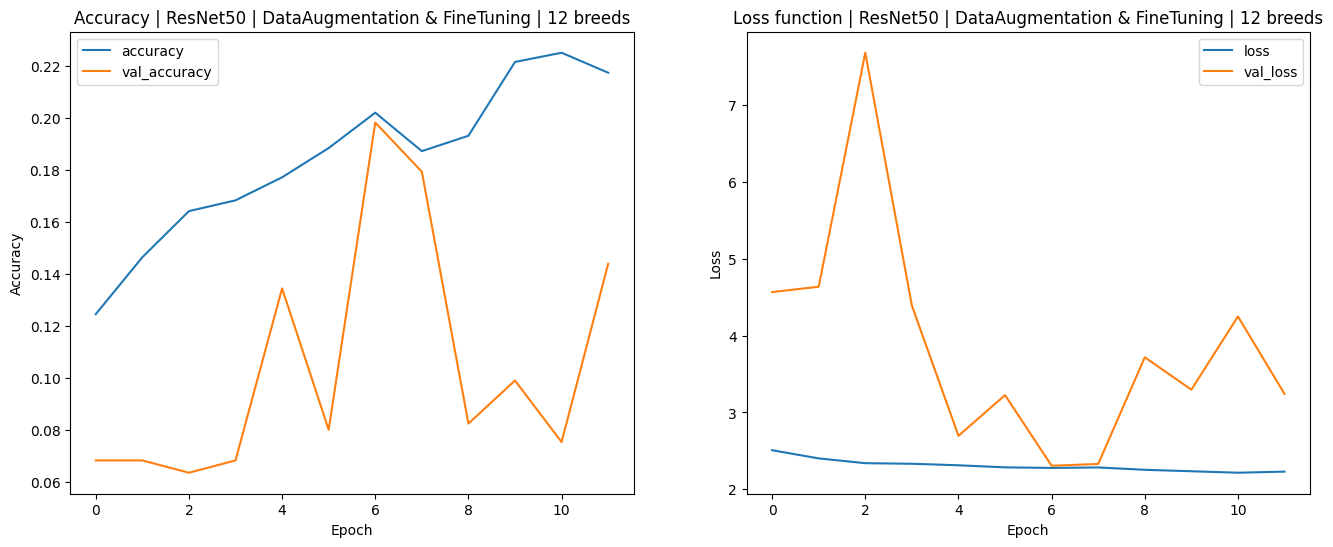

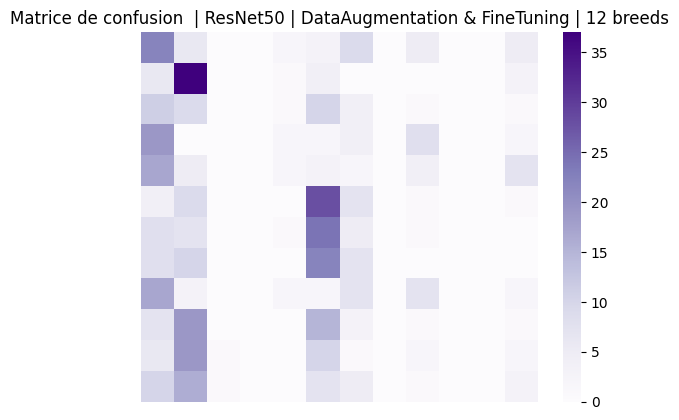

53/53 [==============================] - 3s 53ms/step - loss: 2.2764 - accuracy: 0.1962
Evaluation de MobileNetV2 en cours...
Found 1694 validated image filenames belonging to 12 classes.
Found 1694 validated image filenames belonging to 12 classes.
Found 424 validated image filenames belonging to 12 classes.
Found 530 validated image filenames belonging to 12 classes.
9412608/9406464 [==============================] - 0s 0us/step
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping


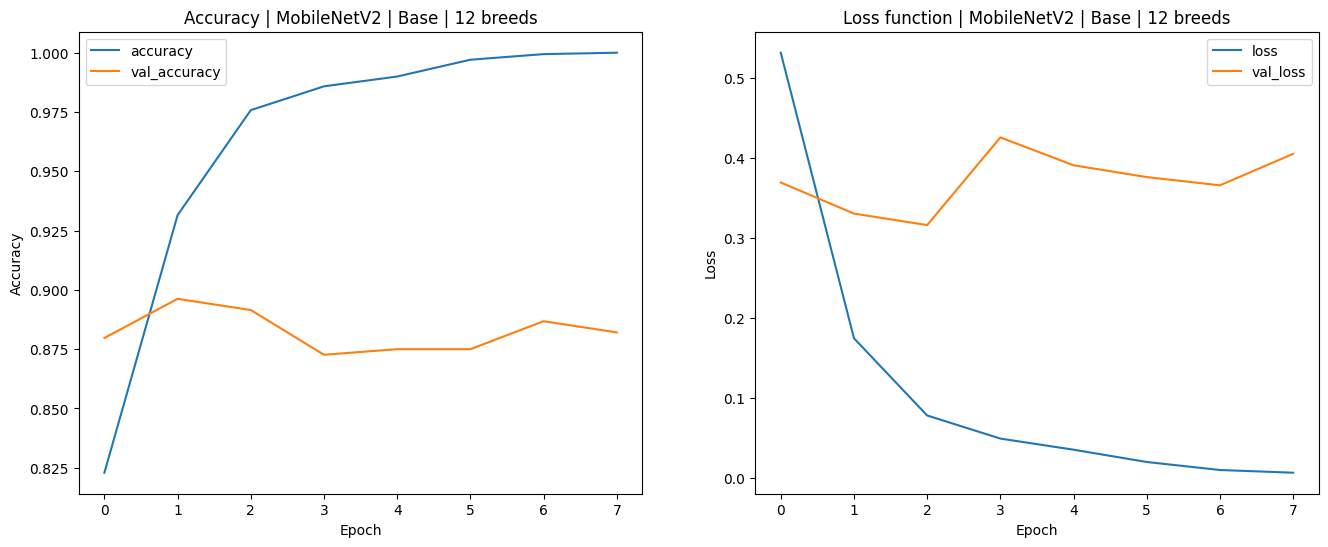

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


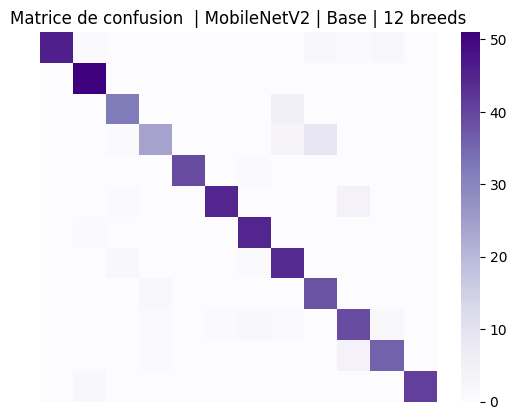

53/53 [==============================] - 2s 44ms/step - loss: 0.2896 - accuracy: 0.9057
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping


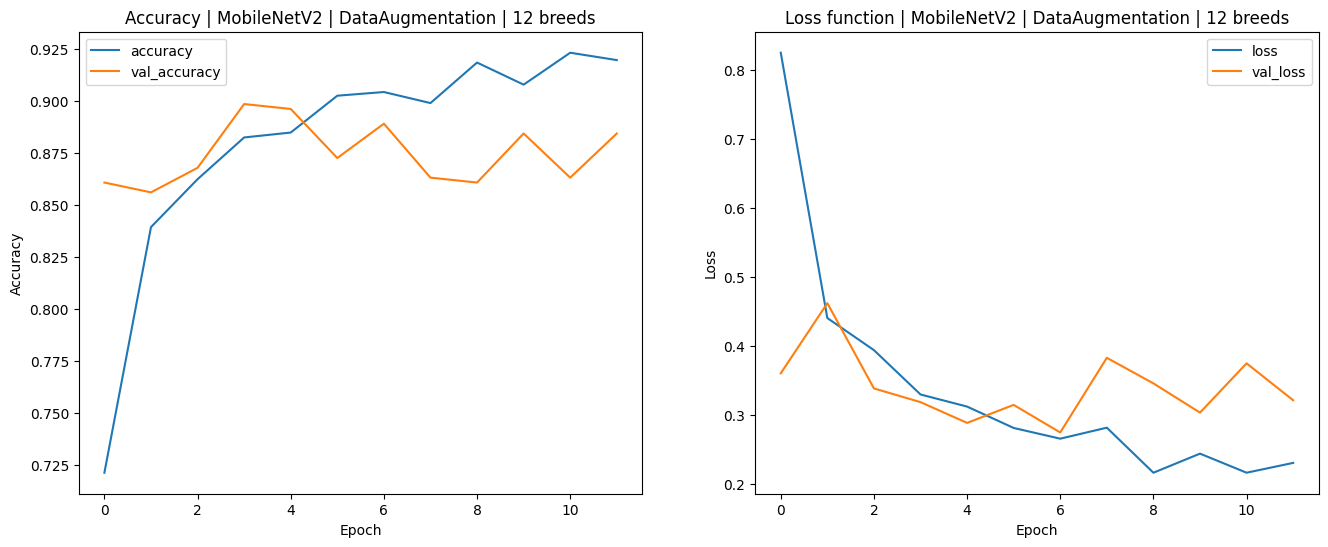

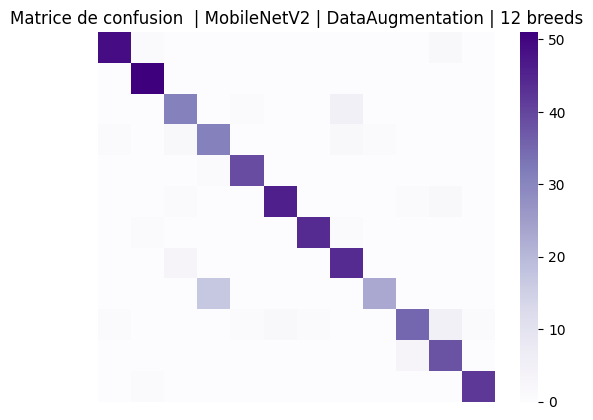

53/53 [==============================] - 2s 44ms/step - loss: 0.2744 - accuracy: 0.8925
Nombre de poids entraînable de MobileNetV2 avant dégel partiel : 0
Nombre de poids entraînable de MobileNetV2 après dégel partiel : 17
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping


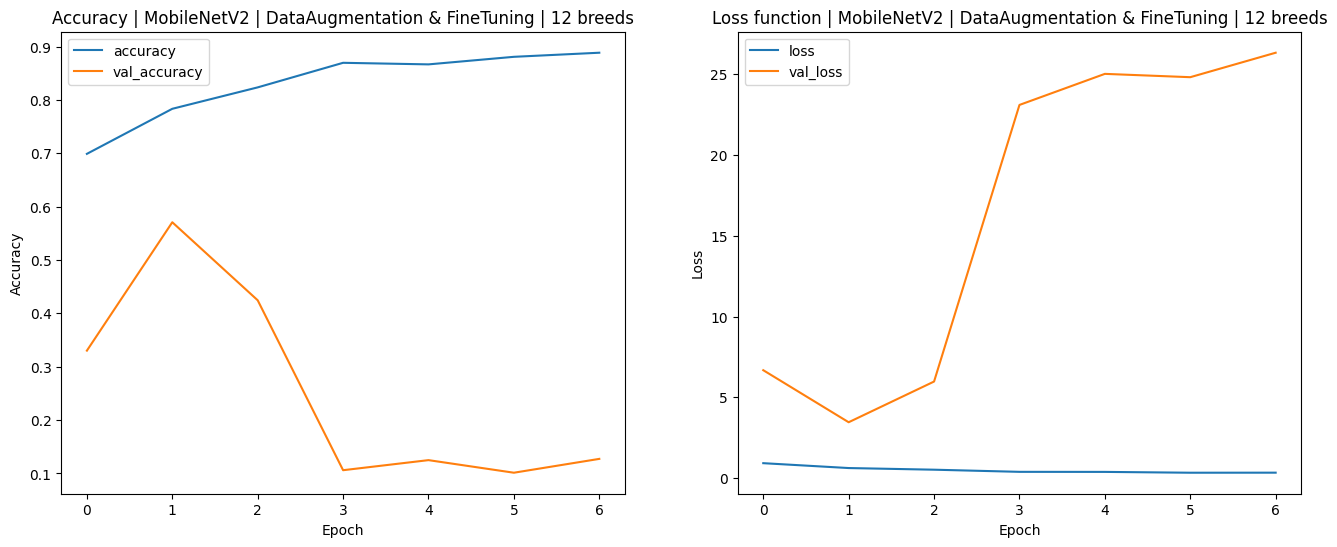

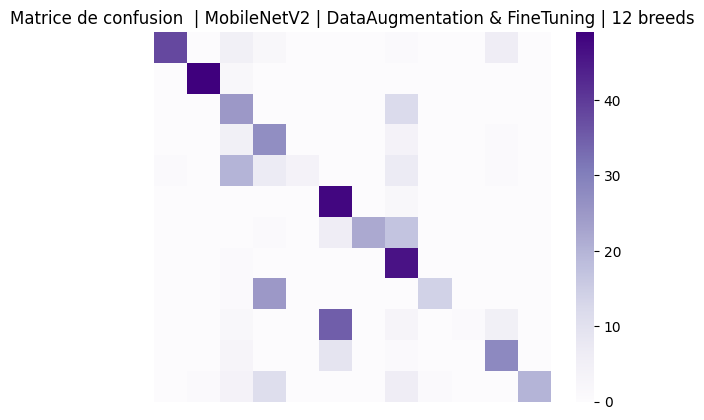

53/53 [==============================] - 2s 44ms/step - loss: 3.0950 - accuracy: 0.6075
Evaluation de InceptionV3 en cours...
Found 1694 validated image filenames belonging to 12 classes.
Found 1694 validated image filenames belonging to 12 classes.
Found 424 validated image filenames belonging to 12 classes.
Found 530 validated image filenames belonging to 12 classes.
87916544/87910968 [==============================] - 1s 0us/step
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


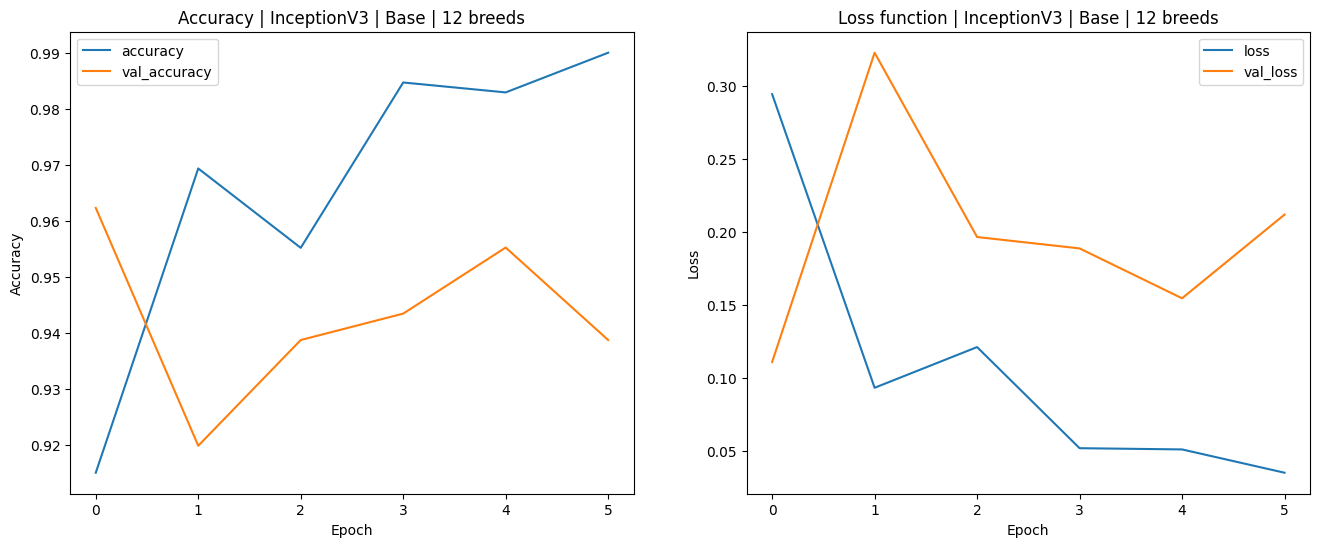

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


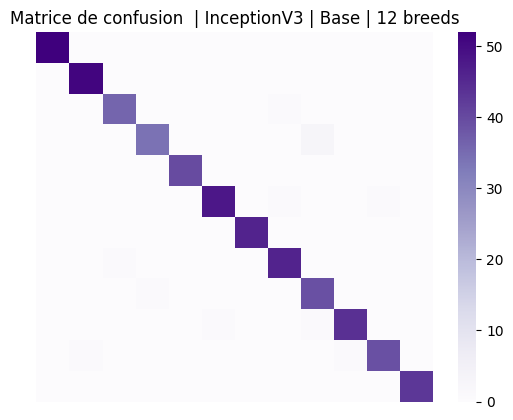

53/53 [==============================] - 3s 61ms/step - loss: 0.0628 - accuracy: 0.9774
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping


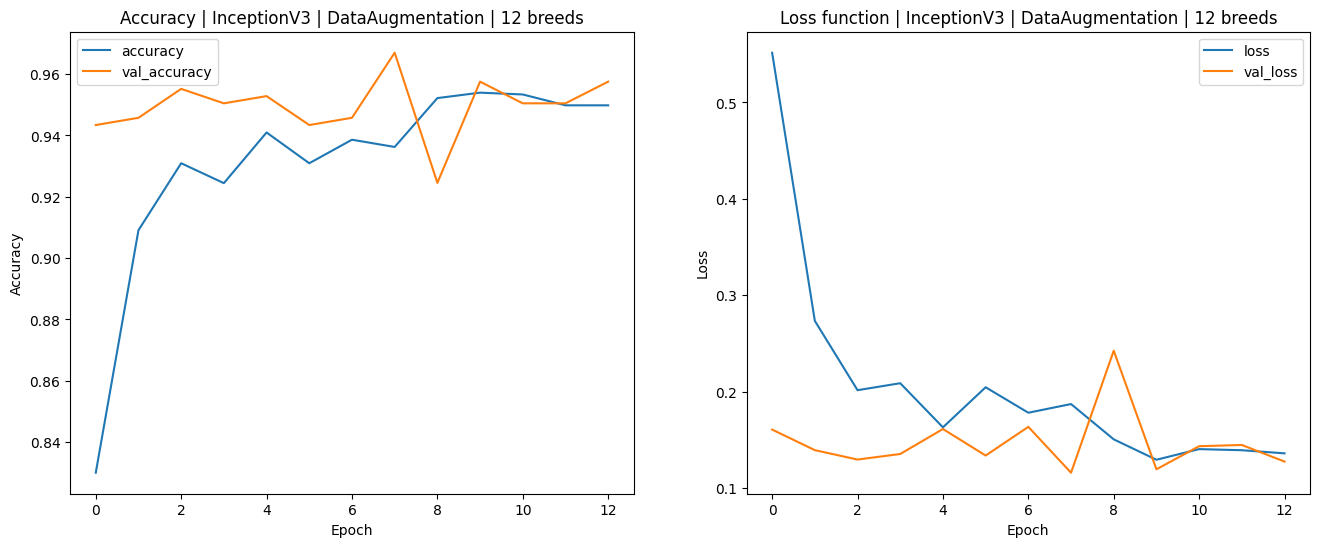

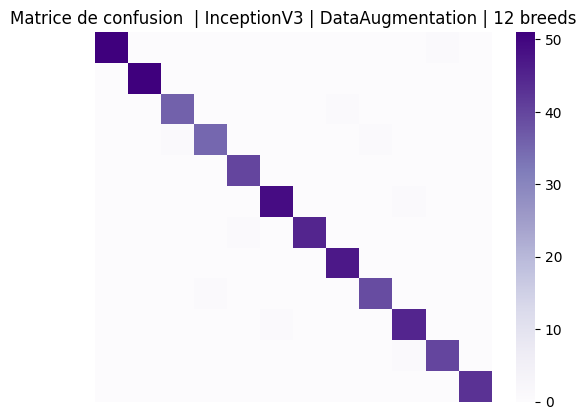

53/53 [==============================] - 3s 61ms/step - loss: 0.0617 - accuracy: 0.9830
Nombre de poids entraînable de InceptionV3 avant dégel partiel : 0
Nombre de poids entraînable de InceptionV3 après dégel partiel : 18
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping


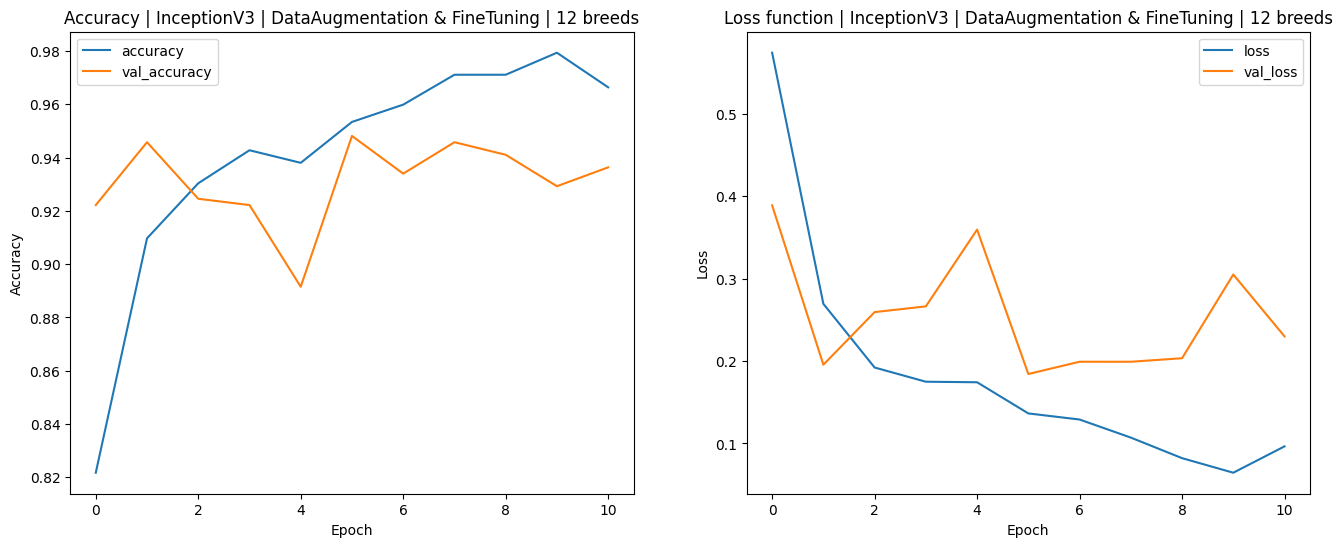

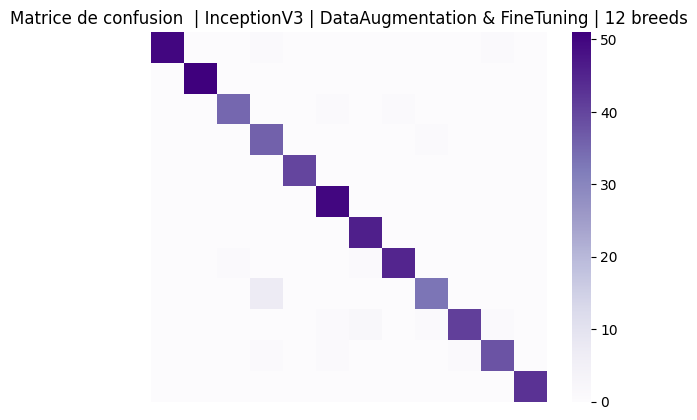

53/53 [==============================] - 3s 58ms/step - loss: 0.1483 - accuracy: 0.9585
Evaluation de Xception en cours...
Found 1694 validated image filenames belonging to 12 classes.
Found 1694 validated image filenames belonging to 12 classes.
Found 424 validated image filenames belonging to 12 classes.
Found 530 validated image filenames belonging to 12 classes.
83689472/83683744 [==============================] - 1s 0us/step
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


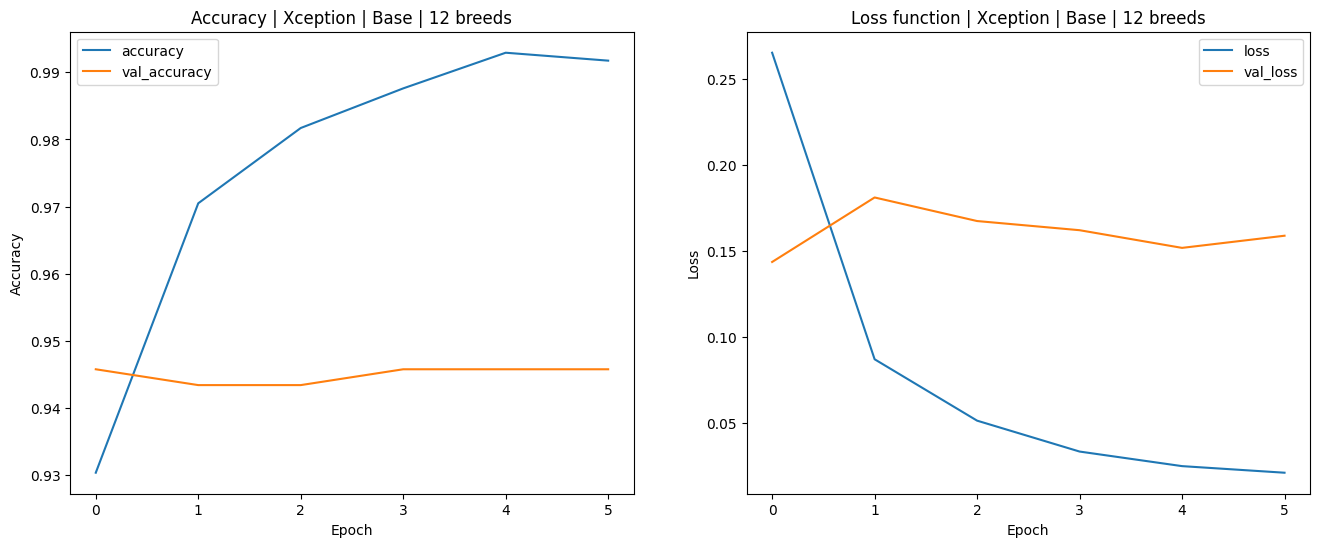

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


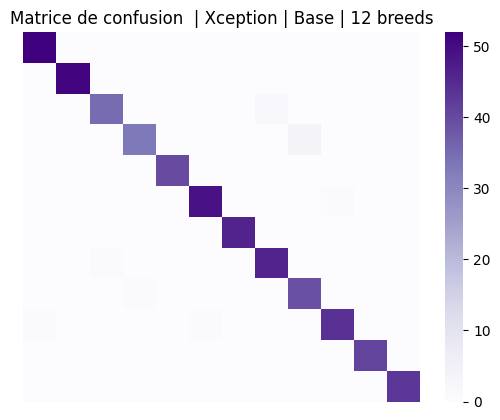

53/53 [==============================] - 4s 65ms/step - loss: 0.0980 - accuracy: 0.9792
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping


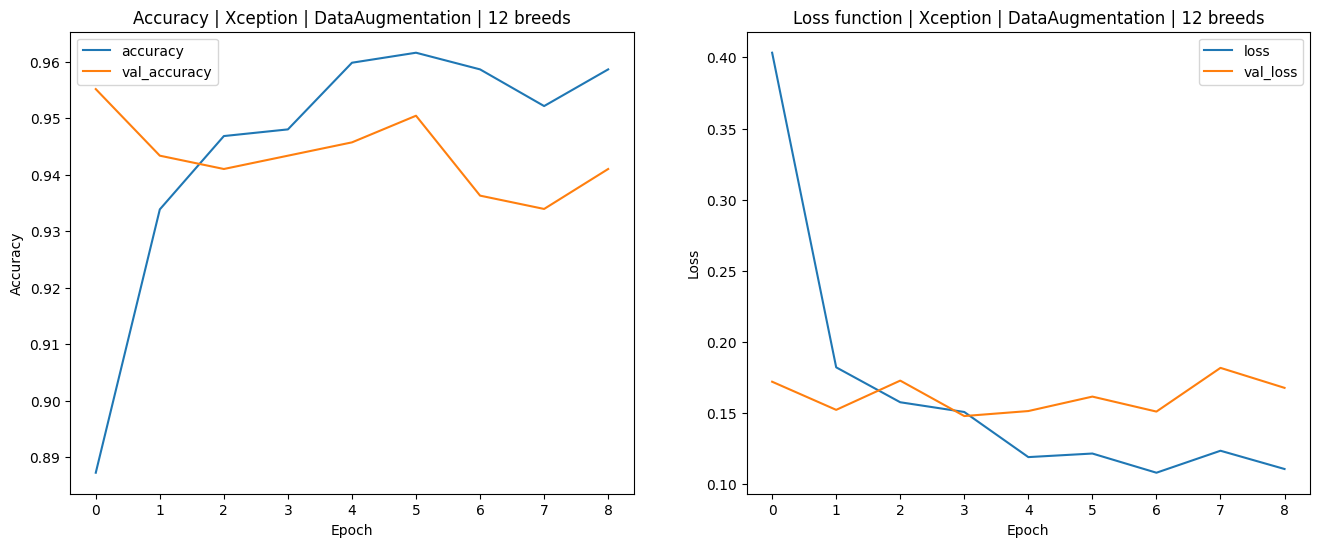

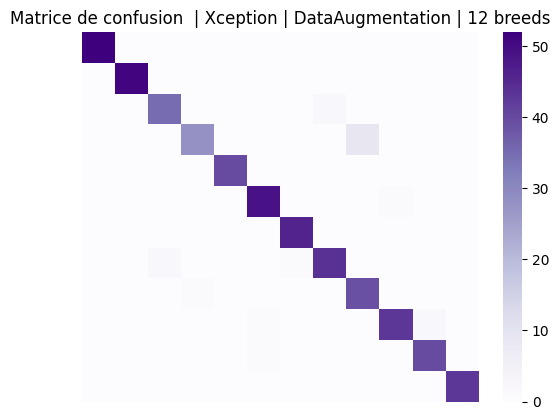

53/53 [==============================] - 4s 66ms/step - loss: 0.1125 - accuracy: 0.9623
Nombre de poids entraînable de Xception avant dégel partiel : 0
Nombre de poids entraînable de Xception après dégel partiel : 17
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping


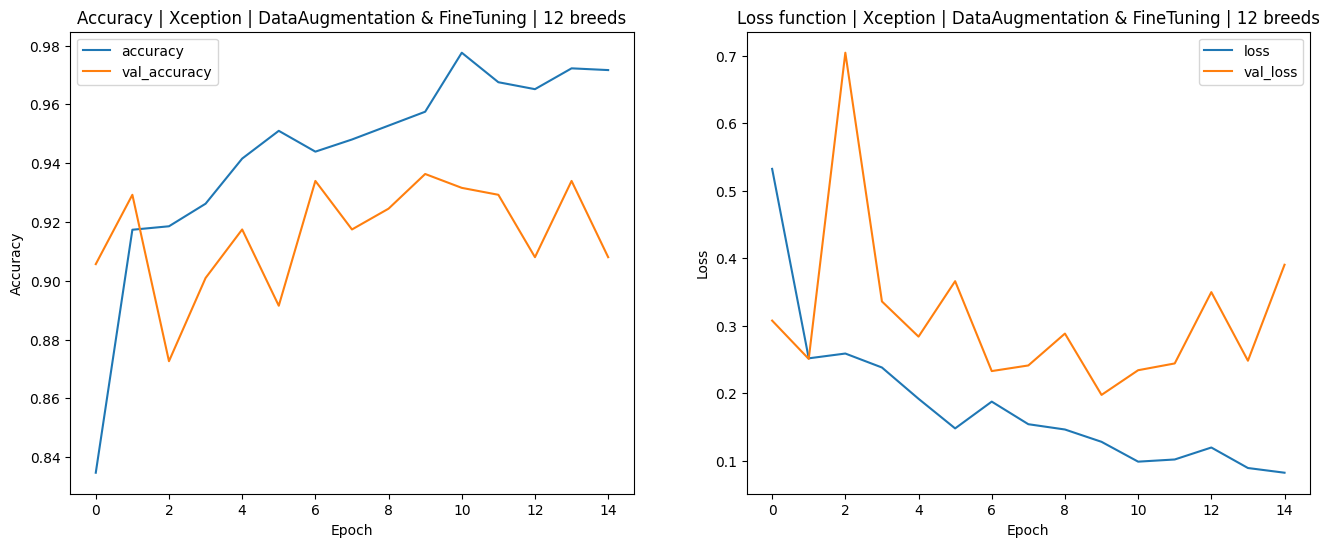

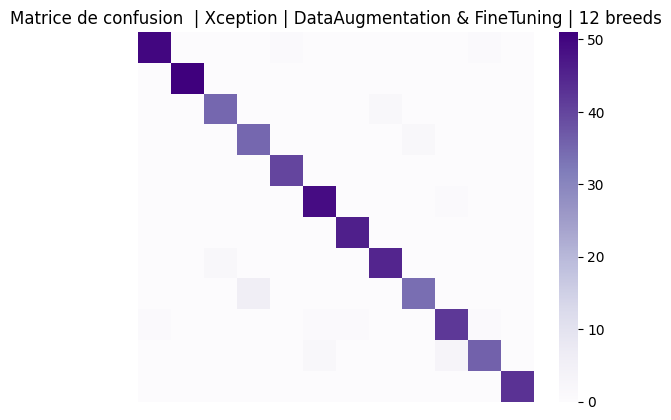

53/53 [==============================] - 4s 68ms/step - loss: 0.1539 - accuracy: 0.9547


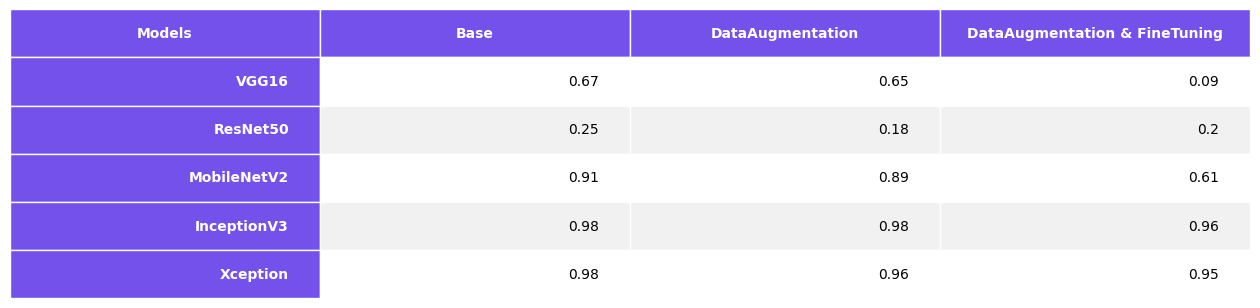

In [4]:
# Paramètrage des modèles (Nom du modèle, Modèle, Taille de l'image en entrée)
models = [('VGG16', VGG16, 224),
          ('ResNet50', ResNet50, 224),
          ('MobileNetV2', MobileNetV2, 224),
          ('InceptionV3', InceptionV3, 299),
          ('Xception', Xception, 299)]

# Paramètrage des données d'entrées
n_breeds = 12
dogs = get_dataframe('../input/stanford-dogs-dataset/images', n_breeds)
print(f"Nous avons {dogs.breeds.nunique()} races sélectionnées pour la phase d'expérimentation.")

# Paramètrage de l'entraînement
epochs = 40
verbose = 0
early_stopping_monitor = EarlyStopping(patience=5, verbose=1, restore_best_weights=True)

# Initialisation des variables résultantes
test_accuracy = {}
results = pd.DataFrame()

for name, model, px in models:
    print(f"Evaluation de {name} en cours...")
    # Création des générateurs
    train_gen, train_gen_data_aug, val_gen, test_gen = split_and_generate_dataframe(dogs, px)
   
    # Chargement et gel de la base convolutionnelle
    conv_base = model(weights='imagenet', include_top=False, input_shape=(px, px, 3))
    conv_base.trainable = False
     
    # Entraînement du modèle standard
    title = "Base"
    model_save = ModelCheckpoint('best_model_' + name + '_' + title + '_' + str(n_breeds) + '_breeds.hdf5', save_best_only=True)
    
    test_accuracy[title] = train_model(train_gen)
    
    row = pd.Series(test_accuracy, name=name)
    
    # Entraînement du modèle avec data augmentation
    title = "DataAugmentation"
    model_save = ModelCheckpoint('best_model_' + name + '_' + title + '_' + str(n_breeds) + '_breeds.hdf5', save_best_only=True)
    
    test_accuracy[title] = train_model(train_gen_data_aug)
    
    row = pd.Series(test_accuracy, name=name)
    
    # Entraînement du modèle avec data augmentation et fine Tuning
    title = "DataAugmentation & FineTuning"
    model_save = ModelCheckpoint('best_model_' + name + '_' + title + '_' + str(n_breeds) + '_breeds.hdf5', save_best_only=True)
    
    print(f'Nombre de poids entraînable de {name} avant dégel partiel : {len(conv_base.trainable_weights)}')
    
    conv_base.trainable = True
    if name == 'VGG16':
        # Pour VGG16, je dégèle le 5ème bloc
        set_trainable = False
        for layer in conv_base.layers:
            if layer.name == 'block5_conv1':
                set_trainable = True
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False
    else:
        # Je dégèle 10 % des dernières couches pour InceptionV3 et Xception
        limit_freeze_layer = int(len(conv_base.layers) * 0.9)
        for layer in conv_base.layers[:limit_freeze_layer]:
            layer.trainable = False
        for layer in conv_base.layers[limit_freeze_layer:]:
            layer.trainable = True
    print(f'Nombre de poids entraînable de {name} après dégel partiel : {len(conv_base.trainable_weights)}')

    
    
    test_accuracy[title] = train_model(train_gen_data_aug)
    
    row = pd.Series(test_accuracy, name=name)
    
    results = results.append(row)

results = results.reset_index().rename(columns={'index': 'Models'})
export_png_table(round(results, 2), col_width=4, filename='./cnn_transfer_learning_results_' + str(n_breeds) + '_breeds.png')

Les résultats des entraînements avec augmentation des données sont les meilleurs. Les formation des modèles de base, fait naïvement, montre un surapprentissage. Le fine tuning tel qu'il est maîtrisé actuellement n'améliore pas les résultats et introduisent du surapprentissage.

---
# 2. Mise à l'échelle | Charge 50 % (60 races)

La mise à l'échelle à 60 races se fait sur les deux meilleurs modèles précédents.

Nous avons 60 races sélectionnées pour la phase d'expérimentation.
Evaluation de InceptionV3 en cours...
Found 7286 validated image filenames belonging to 60 classes.
Found 7286 validated image filenames belonging to 60 classes.
Found 1822 validated image filenames belonging to 60 classes.
Found 2278 validated image filenames belonging to 60 classes.
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping


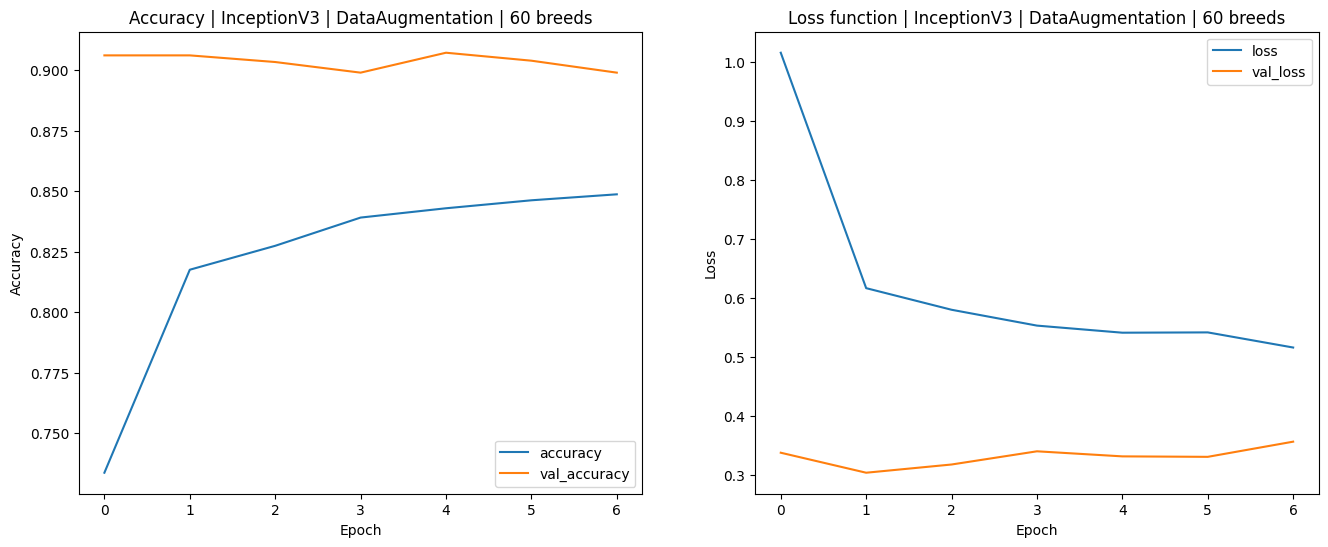

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


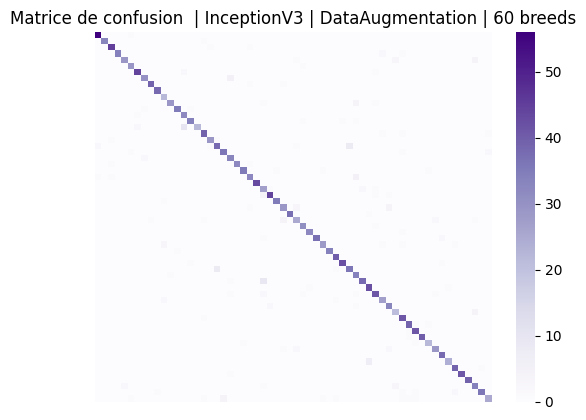

67/67 [==============================] - 15s 228ms/step - loss: 0.2818 - accuracy: 0.9083
Evaluation de Xception en cours...
Found 7286 validated image filenames belonging to 60 classes.
Found 7286 validated image filenames belonging to 60 classes.
Found 1822 validated image filenames belonging to 60 classes.
Found 2278 validated image filenames belonging to 60 classes.
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping


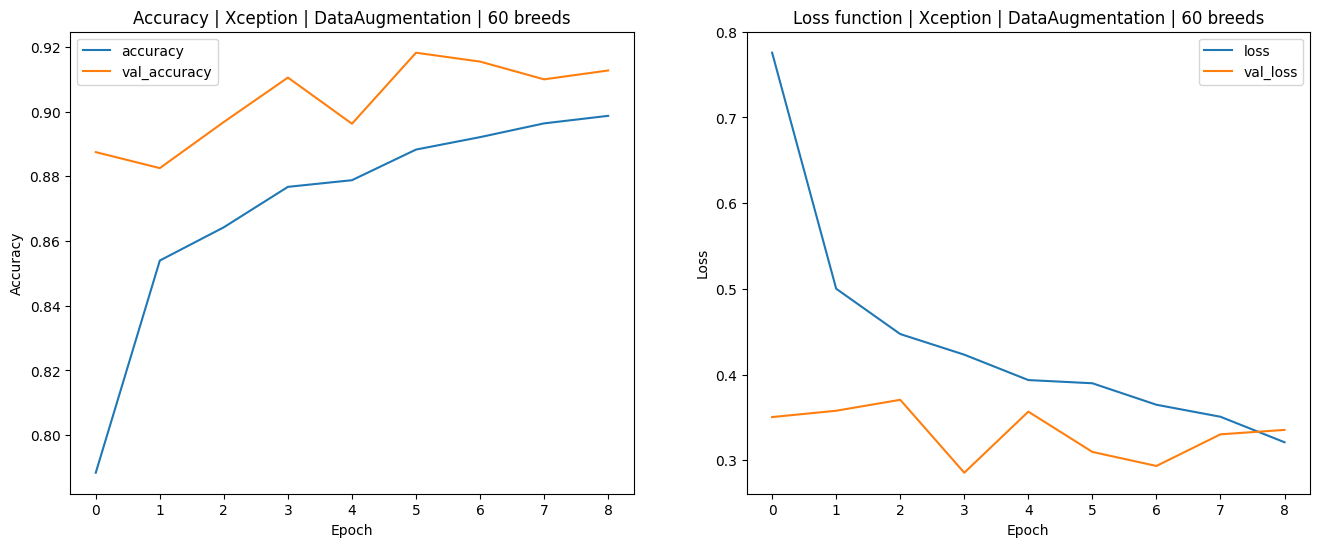

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


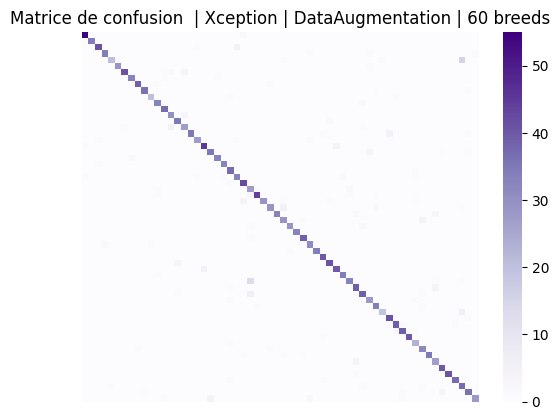

67/67 [==============================] - 16s 240ms/step - loss: 0.3290 - accuracy: 0.9056


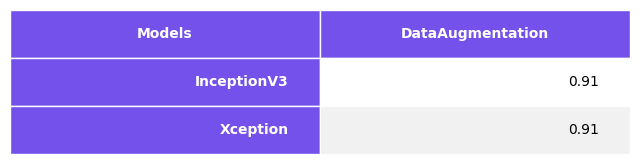

In [5]:
# Paramètrage des modèles (Nom du modèle, Modèle, Taille de l'image en entrée)
models = [('InceptionV3', InceptionV3, 299),
          ('Xception', Xception, 299)]

# Paramètrage des données d'entrées
n_breeds = 60
dogs = get_dataframe('../input/stanford-dogs-dataset/images', n_breeds)
print(f"Nous avons {dogs.breeds.nunique()} races sélectionnées pour la phase d'expérimentation.")

# Paramètrage de l'entraînement
epochs = 40
verbose = 0
early_stopping_monitor = EarlyStopping(patience=5, verbose=1, restore_best_weights=True)

# Initialisation des variables résultantes
test_accuracy = {}
results = pd.DataFrame()

for name, model, px in models:
    print(f"Evaluation de {name} en cours...")
    # Création des générateurs
    train_gen, train_gen_data_aug, val_gen, test_gen = split_and_generate_dataframe(dogs, px)
   
    # Chargement et gel de la base convolutionnelle
    conv_base = model(weights='imagenet', include_top=False, input_shape=(px, px, 3))
    conv_base.trainable = False
    
    # Entraînement du modèle avec data augmentation
    title = "DataAugmentation"
    model_save = ModelCheckpoint('best_model_' + name + '_' + title + '_' + str(n_breeds) + '_breeds.hdf5', save_best_only=True)
    
    test_accuracy[title] = train_model(train_gen_data_aug)
    
    row = pd.Series(test_accuracy, name=name)
    
    results = results.append(row)

results = results.reset_index().rename(columns={'index': 'Models'})
export_png_table(round(results, 2), col_width=4, filename='./cnn_transfer_learning_results_' + str(n_breeds) + '_breeds.png')

---
# 3. Mise à l'échelle | Charge 100% (120 races)

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default")
import seaborn as sns
import six

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception

In [7]:
# Création des fonctions
def get_dataframe(path, n_breeds=12):
    dogs_lst = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            dogs_lst.append(os.path.join(dirname, filename))

    # Je stocke dans un dataframe
    dogs_raw = pd.DataFrame(dogs_lst, columns=['uri'])

    # J'extrais la race
    dogs_raw['breeds'] = dogs_raw.uri.str.split('/').str.get(5).str.slice(10)
    
    # Délimitation du nombre de race
    top_breeds = dogs_raw.groupby('breeds').count().sort_values(by='uri', ascending=False).head(n_breeds).reset_index().breeds.to_list()
    dogs = pd.DataFrame()
    for b in top_breeds:
        dogs = dogs.append(dogs_raw[dogs_raw.breeds == b])

    return dogs


def split_and_generate_dataframe(df, px):
    seed = 42

    # Séparation des données d'entrainements et de tests
    train, test = train_test_split(df, test_size=0.2, random_state=seed)
    # Séparation des données d'entrainements et de validation
    train, val = train_test_split(train, test_size=0.2, random_state=seed)

    ### Paramétrage
    x = 'uri'
    y = 'breeds'

    train_batch_size = get_batch_size(len(train))
    val_batch_size = get_batch_size(len(val))
    test_batch_size = get_batch_size(len(test))

    train_datagen = ImageDataGenerator(rescale=1./255)
    train_datagen_aug = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Sans augmentation des données
    train_gen = train_datagen.flow_from_dataframe(
                      train,
                      x_col='uri',
                      y_col='breeds',
                      target_size=(px, px),
                      batch_size=train_batch_size,
                      seed=seed
                      )


    # Avec augmentation des données
    train_gen_data_aug = train_datagen_aug.flow_from_dataframe(
                              train,
                              x_col='uri',
                              y_col='breeds',
                              target_size=(px, px),
                              batch_size=train_batch_size,
                              seed=seed
                              )

    val_gen = val_test_datagen.flow_from_dataframe(
                      val,
                      x_col = x,
                      y_col = y,
                      target_size=(px, px),
                      batch_size=val_batch_size,
                      seed=seed
                      )

    test_gen = val_test_datagen.flow_from_dataframe(
                      test,
                      x_col = x,
                      y_col = y,
                      target_size=(px, px),
                      batch_size=test_batch_size,
                      seed=seed,
                      shuffle=False
                      )

    return [train_gen, train_gen_data_aug, val_gen, test_gen]

def get_batch_size(gen):
    lst = []
    dict = {}
    
    # Test des nombres entiers et intégration dans un dictionnaire
    for i in range(1,40):
        dict[i] = gen % i
    
    # Récupération du plus grand nombre entiers
    for key, value in dict.items():
        if value == 0:
            lst.append(key)

    return max(lst)


def get_model():
    model = Sequential()
    model.add(conv_base)
    model.add(GlobalAveragePooling2D())
    # model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(len(train_gen.class_indices), activation='softmax'))
    return model


def train_model(train):
    model_train = get_model()
    model_train.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    history_train = model_train.fit(train,
                                validation_data=val_gen,
                                epochs=epochs,
                                verbose=verbose,
                                callbacks=[early_stopping_monitor, model_save])
    
    plot_result_fitting(history_train, name, title, n_breeds)
    plot_confusion_matrix(model_train, name, title, n_breeds)
    
    return model_train.evaluate(test_gen)[1]


def plot_result_fitting(history, model, title, n_breeds):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
    ax[0].set_title('Accuracy | ' + model + ' | ' + title + ' | ' + str(n_breeds) + ' breeds')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='loss')
    ax[1].plot(history.history['val_loss'], label = 'val_loss')
    ax[1].set_title('Loss function | ' + model + ' | ' + title + ' | ' + str(n_breeds) + ' breeds')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.savefig('./cnn_transfer_learning_' + model + '_' + title + '_' + str(n_breeds) + '_breeds_results.png',
                transparent=True)
    plt.show()
    return None


def export_png_table(data, col_width=2.2, row_height=0.625, font_size=10,
                     header_color='#7451eb', row_colors=['#f1f1f2', 'w'],
                     edge_color='w', bbox=[0, 0, 1, 1], header_columns=1,
                     ax=None, filename='table.png', **kwargs):
    ax = None
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])
                ) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox,
                         colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])

    fig.savefig(filename, transparent=True)

    return None

def plot_confusion_matrix(model, name, title, n_breeds):
    pred = model.predict_classes(test_gen) #model.predict()
    cf_matrix = confusion_matrix(test_gen.classes, pred)
    sns.heatmap(cf_matrix, cmap='Purples')
    plt.title('Matrice de confusion  | ' + name + ' | ' + title + ' | ' + str(n_breeds) + ' breeds')
    plt.axis('off')
    plt.savefig('./cnn_transfer_learning_' + name + '_' + title + '_' + str(n_breeds) + '_breeds_confusion_matrix.png',
                transparent=True)
    plt.show()
    return

Nous avons 120 races sélectionnées
Evaluation de Xception en cours...
Found 13171 validated image filenames belonging to 120 classes.
Found 13171 validated image filenames belonging to 120 classes.
Found 3293 validated image filenames belonging to 120 classes.
Found 4116 validated image filenames belonging to 120 classes.
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping


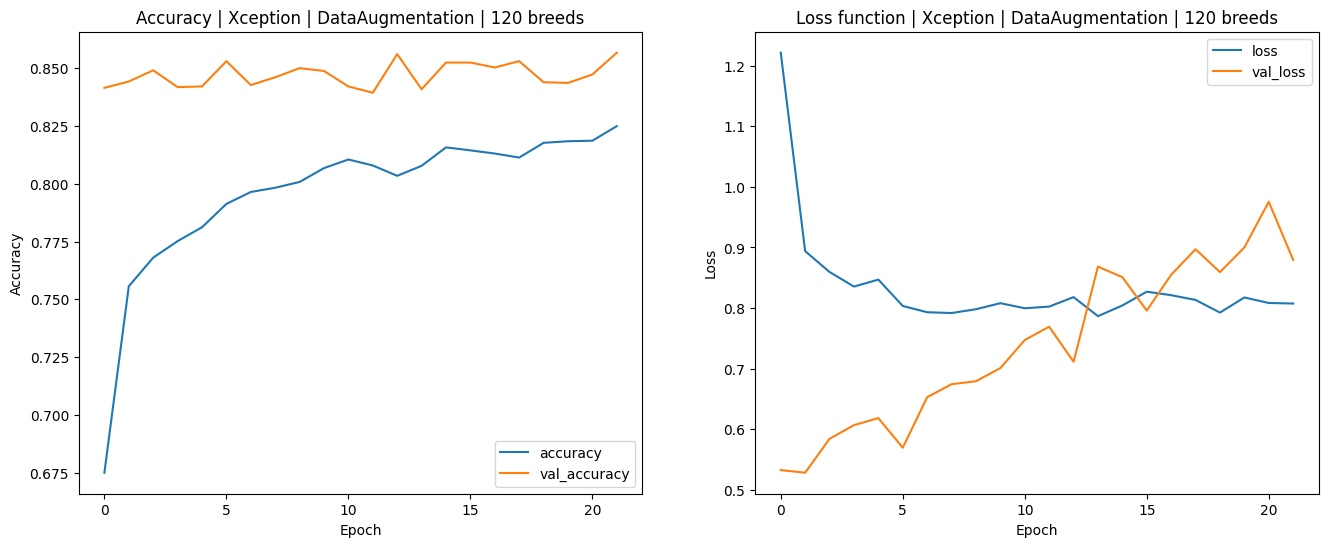

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


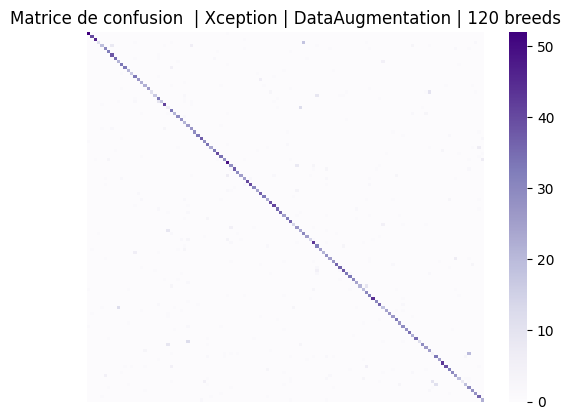

147/147 [==============================] - 26s 176ms/step - loss: 0.5899 - accuracy: 0.8377


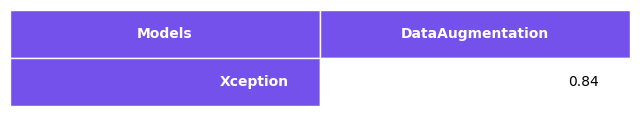

In [8]:
# Paramètrage des modèles (Nom du modèle, Modèle, Taille de l'image en entrée)
models = [('Xception', Xception, 299)]


# Paramètrage des données d'entrées
n_breeds = 120
dogs = get_dataframe('../input/stanford-dogs-dataset/images', n_breeds)
print(f"Nous avons {dogs.breeds.nunique()} races sélectionnées")

# Paramètrage de l'entraînement
epochs = 40
verbose = 0
early_stopping_monitor = EarlyStopping(patience=20, verbose=1, restore_best_weights=True)

# Initialisation des variables résultantes
test_accuracy = {}
results = pd.DataFrame()

for name, model, px in models:
    print(f"Evaluation de {name} en cours...")
    # Création des générateurs
    train_gen, train_gen_data_aug, val_gen, test_gen = split_and_generate_dataframe(dogs, px)
   
    # Chargement et gel de la base convolutionnelle
    conv_base = model(weights='imagenet', include_top=False, input_shape=(px, px, 3))
    conv_base.trainable = False

    
    # Entraînement du modèle avec data augmentation
    title = "DataAugmentation"
    model_save = ModelCheckpoint('best_model_' + name + '_' + title + '_' + str(n_breeds) + '_breeds.hdf5', save_best_only=True)
    
    test_accuracy[title] = train_model(train_gen_data_aug)
    
    row = pd.Series(test_accuracy, name=name)
    results = results.append(row)

results = results.reset_index().rename(columns={'index': 'Models'})
export_png_table(round(results, 2), col_width=4, filename='./cnn_transfer_learning_results_' + str(n_breeds) + '_breeds.png')

Nous avons 120 races sélectionnées
Evaluation de InceptionV3 en cours...
Found 13171 validated image filenames belonging to 120 classes.
Found 13171 validated image filenames belonging to 120 classes.
Found 3293 validated image filenames belonging to 120 classes.
Found 4116 validated image filenames belonging to 120 classes.
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping


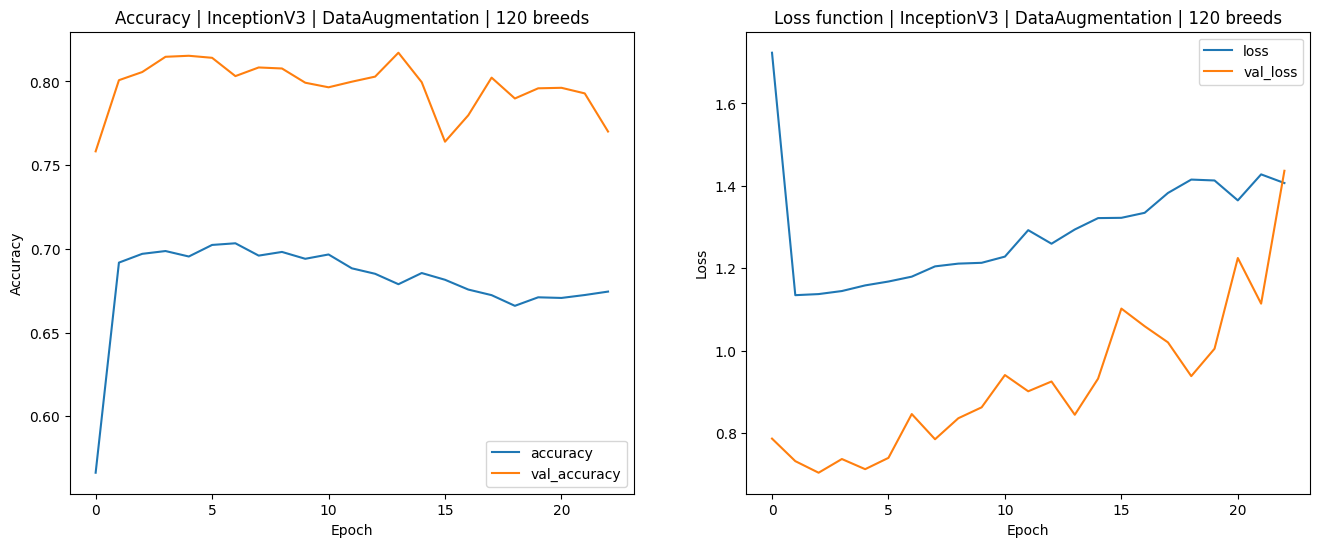

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


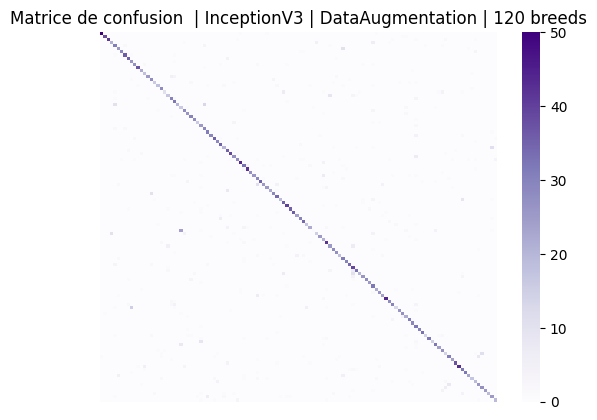

147/147 [==============================] - 24s 161ms/step - loss: 0.7215 - accuracy: 0.8027


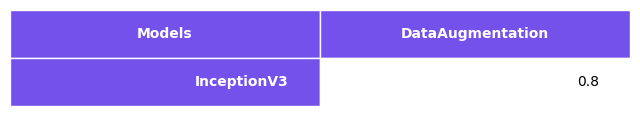

In [9]:
# Paramètrage des modèles (Nom du modèle, Modèle, Taille de l'image en entrée)
models = [('InceptionV3', InceptionV3, 299)]


# Paramètrage des données d'entrées
n_breeds = 120
dogs = get_dataframe('../input/stanford-dogs-dataset/images', n_breeds)
print(f"Nous avons {dogs.breeds.nunique()} races sélectionnées")

# Paramètrage de l'entraînement
epochs = 40
verbose = 0
early_stopping_monitor = EarlyStopping(patience=20, verbose=1, restore_best_weights=True)

# Initialisation des variables résultantes
test_accuracy = {}
results = pd.DataFrame()

for name, model, px in models:
    print(f"Evaluation de {name} en cours...")
    # Création des générateurs
    train_gen, train_gen_data_aug, val_gen, test_gen = split_and_generate_dataframe(dogs, px)
   
    # Chargement et gel de la base convolutionnelle
    conv_base = model(weights='imagenet', include_top=False, input_shape=(px, px, 3))
    conv_base.trainable = False

    
    # Entraînement du modèle avec data augmentation
    title = "DataAugmentation"
    model_save = ModelCheckpoint('best_model_' + name + '_' + title + '_' + str(n_breeds) + '_breeds.hdf5', save_best_only=True)
    
    test_accuracy[title] = train_model(train_gen_data_aug)
    
    row = pd.Series(test_accuracy, name=name)
    results = results.append(row)

results = results.reset_index().rename(columns={'index': 'Models'})
export_png_table(round(results, 2), col_width=4, filename='./cnn_transfer_learning_results_' + str(n_breeds) + '_breeds.png')